In [1]:
# Load libraries
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import networkx as nx
import operator

In [2]:
# Define function that would create a sorted list, from highest to lowest
# This function was taken from page 47 from "Social Network Analysis for Startups".

def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda (k,v): (-v,k)) 
    return ms

In [3]:
# Retrieve data from the database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, 
                          user='root', passwd='data620pw',
                          db='reddit')

reddit = pd.read_sql('SELECT DISTINCT author, responder, COUNT(1) as weight FROM comments '
                     'GROUP BY author, responder '
                     'HAVING author<>"[deleted]" AND responder<>"[deleted]";', con=sql_con)

# Import users with centrality measures previously calculated
# Just so we don't have to wait for them every time
users = pd.read_sql('SELECT username, betweenness, degree FROM users', con=sql_con)
 
sql_con.close()

In [4]:
# Data test
reddit.loc[0:5]

,author,responder,weight
0,---DevilsAdvocate---,dannybtw,1
1,---DevilsAdvocate---,ThisFreaknGuy,2
2,-Covariance,DomeSlave,1
3,-Mountain-King-,ASK_ABOUT_STEELBEAMS,3
4,-Mountain-King-,AvoidNoiderman,2
5,-Mountain-King-,Bigfrostynugs,1


In [5]:
# Initialize graph
G = nx.Graph()

# Add nodes
nodes = set(reddit.loc[:, "author"])
nodes.union(set(reddit.loc[:, "responder"]))
nodes = list(nodes)
nodes
G.add_nodes_from(nodes)

# Add edges with weights
# Weight is equal to number of interactions between users
#G.add_edges_from([tuple(x) for x in reddit.loc[:, "author":"responder"].values])
G.add_weighted_edges_from([tuple(x) for x in reddit.values])

In [6]:
nx.number_of_nodes(G)

10233

Let's confirm that the graph is fully connected.

In [7]:
nx.number_connected_components(G)

129

In [8]:
# Ten largest subgraphs
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)[0:10]]

[9928, 9, 6, 5, 5, 5, 5, 5, 4, 4]

The graph is not fully connected. Most likely this is due to deleted user accounts that connected islands consisting of just a few nodes to the main subgraph. Let's remove all small islands and concentrate on the main subgraph.

In [9]:
# Select the largest connected subgraph
G = max(nx.connected_component_subgraphs(G), key=len)
G.number_of_nodes()

9928

Initially, we considered trimming the graph. For example, removing nodes with only 1 or 2 degrees. However, considering that we are dealing with online forum, there will be a significant number of users who only responded once to one comment. These leaves influence centralities of connected nodes and therefore are necessary for our analysis.

In [10]:
# Trim the graph removing any nodes with less than 3 degrees
# remove = [node for node,degree in G.degree().items() if degree < 3]
#G.remove_nodes_from(remove)
#G.number_of_nodes()

In [13]:
'''
The following code was used to calculate centralities during first run
Betweenness centrality takes a long time to calculate 
As such we use saved values for further analysis

# Calculate betweenness centrality
centr_bw = nx.betweenness_centrality(G, weight='weight')

# Calculate degree centrality
centr_deg = nx.degree_centrality(G)
'''

users[0:25]

,username,betweenness,degree
0,CDC_,0.087609,0.035560
1,corby315,0.074198,0.023471
2,fundygud,0.051563,0.020248
3,Lemonaxe,0.049766,0.021557
4,bazzil350,0.049644,0.019845
5,hawkish25,0.049423,0.017125
6,Supersoakthatho,0.048042,0.017729
7,FenrisCain,0.046511,0.018535
8,ohitsali,0.045828,0.018535
9,mstrdpncks,0.045789,0.017528


Let's look at one user. **Bt1222** is in the top 20 list for degree centrality, but he or she just misses the top 20 list for betweenness centrality.

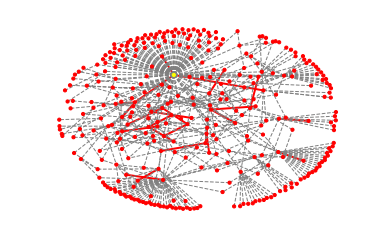

In [14]:
main = 'Bt1222'

# Select neighbors and neighbors of neighbors
subG = G.neighbors(main)
n_list = subG
for n in subG:
    n_list = n_list + G.neighbors(n)
n_list = list(set(n_list))
n_list.append(main)

# Isolate the subnetwork
subG = G.subgraph(n_list)

# Get color map
colormap =[]
for n in subG.nodes():
    if n==main:
        colormap.append('yellow')
    else:
        colormap.append('red')
     
# Separate edges by weight - 1 and more than 1
elarge=[(u,v) for (u,v,d) in subG.edges(data=True) if d['weight']>1]
esmall=[(u,v) for (u,v,d) in subG.edges(data=True) if d['weight']==1]

# Layout
pos=nx.spring_layout(subG)

# Draw nodes
nx.draw_networkx_nodes(subG,pos,node_color=colormap,node_size=10)

# Draw edges
nx.draw_networkx_edges(subG, pos, edgelist=elarge, width=2, edge_color='r')
nx.draw_networkx_edges(subG, pos, edgelist=esmall, width=1, edge_color='grey', style='dashed')

plt.axis('off')
plt.show()

User **Bt1222** is highlighted in yellow. Dashed grey edges are just a single interaction between users. Solid red edges are multiple (2 or more) interactions.

In [17]:
'''
The following code was used to combine centralities into a single data frame
Since the values were saved there is no need to run it

# Combine betweenness and degree centralities into a single data frame

df1 = pd.DataFrame(list(centr_bw.items()), columns=['User', 'Betweenness'])
df2 = pd.DataFrame(list(centr_deg.items()), columns=['User', 'Degree'])
users = df1.join(df2.set_index('User'), on='User')
users.sort_values(['Betweenness', 'Degree'], ascending = False, inplace=True)
'''

users[0:5]

,username,betweenness,degree
0,CDC_,0.087609,0.035560
1,corby315,0.074198,0.023471
2,fundygud,0.051563,0.020248
3,Lemonaxe,0.049766,0.021557
4,bazzil350,0.049644,0.019845


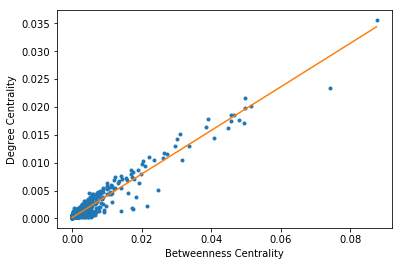

In [19]:
import numpy as np

x = users.loc[:,"betweenness"].values
y = users.loc[:,"degree"].values

# Least squares polynomial fit
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.xlabel("Betweenness Centrality")
plt.ylabel("Degree Centrality")
plt.show()

In [20]:
# Compute Pearson correlation coefficient and the p-value for testing non-correlation
import scipy.stats

scipy.stats.pearsonr(x, y)

(0.96623334983246367, 0.0)